# 1st_week_sales_pred_v005

In [1]:
import os
import sys
import gc
import itertools
import pickle
import pathlib
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [2]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [3]:
SEED = 42
FOLD_N = 5

ディレクトリ設定

In [4]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = '1st_week_sales_pred_v005'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [5]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
#customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
#sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

In [6]:
# label_encoding
le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for c in le_cols:
    le = LabelEncoder()
    articles[c] = le.fit_transform(articles[c].fillna(''))
    articles[c] = articles[c].astype('category')

In [7]:
# detail_desc特徴量
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

detail_desc_n_dim = 50
text_col = 'detail_desc'
articles[text_col] = articles[text_col].str.lower()
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
text_tfidf = tfidf_vec.fit_transform(articles[text_col].fillna('').values.tolist())
svd = TruncatedSVD(n_components=detail_desc_n_dim, algorithm='arpack',random_state=42)

text_svd = svd.fit_transform(text_tfidf)
text_svd_df = pd.DataFrame(text_svd, columns=[f'{text_col}_svd_{i}' for i in range(detail_desc_n_dim)])
articles = pd.concat([articles, text_svd_df], axis=1)

In [8]:
prod_name_n_dim = 50
text_col = 'prod_name'
articles[text_col] = articles[text_col].str.lower()
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
text_tfidf = tfidf_vec.fit_transform(articles[text_col].fillna('').values.tolist())
svd = TruncatedSVD(n_components=prod_name_n_dim, algorithm='arpack',random_state=42)

text_svd = svd.fit_transform(text_tfidf)
text_svd_df = pd.DataFrame(text_svd, columns=[f'{text_col}_svd_{i}' for i in range(prod_name_n_dim)])
articles = pd.concat([articles, text_svd_df], axis=1)

In [9]:
transactions['1st_tran_dat'] = transactions.groupby('article_id')['t_dat'].transform('min')
transactions['1st_tran_dat_diff'] = (transactions['t_dat'] - transactions['1st_tran_dat']).dt.days
transactions2 = transactions[(transactions['1st_tran_dat'] > '2019-09-20') & (transactions['1st_tran_dat_diff'] <= 7)].copy()
transactions2 = transactions.reset_index(drop=True)

In [10]:
train = transactions2.groupby('article_id').agg({'t_dat':'count', '1st_tran_dat':'min'}).reset_index()
train.columns = ['article_id', '1st_week_sales', '1st_week_sales_dat']
train = train.merge(articles, on='article_id', how='left')

In [11]:
test = articles[~articles['article_id'].isin(transactions['article_id'].unique().tolist())].copy()
test['1st_week_sales_dat'] = datetime.datetime(2020,9,23)

# modeling

In [12]:
params = {
    "objective": "mae",
    "boosting" : "gbdt",
    "learning_rate": 0.1,
    "metric": "mae",
    "seed": SEED
}

In [13]:
target = '1st_week_sales'
features = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
features = features + [f'detail_desc_svd_{i}' for i in range(detail_desc_n_dim)]
features = features + [f'prod_name_svd_{i}' for i in range(prod_name_n_dim)]

In [14]:
fi = pd.DataFrame()
oof = train[['article_id', '1st_week_sales_dat', '1st_week_sales']].copy()
oof['1st_week_sales_pred'] = np.nan
preds = np.zeros(len(test))
cv_scores = []

kf = KFold(n_splits=FOLD_N, random_state=SEED, shuffle=True)
for n, (tr_idx, vl_idx) in enumerate(kf.split(train)):

    print(f'fold{n} ' + '--'*10)
    tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
    vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['fold'] = n
    fi = fi.append(fi_tmp)

    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    oof.loc[vl_idx, '1st_week_sales_pred'] = vl_pred

    pred = model.predict(test[features], num_iteration=model.best_iteration)
    preds += pred / FOLD_N

    cv_score = mean_squared_error(vl_y, vl_pred, squared=False)
    cv_scores.append(cv_score)
    print(f'fold{n} RMSE: ' + '{:.5f}'.format(cv_score))

test['1st_week_sales_pred'] = pred
print(f'CV SCORE: ' + '{:.5f}'.format(np.mean(cv_scores)))

fold0 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26073
[LightGBM] [Info] Number of data points in the train set: 83637, number of used features: 111
[LightGBM] [Info] Start training from score 64.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1000]	training's l1: 184.799	valid_1's l1: 214.416
[2000]	training's l1: 170.177	valid_1's l1: 210.058
[3000]	training's l1: 159.458	valid_1's l1: 207.585
Early stopping, best iteration is:
[3017]	training's l1: 159.433	valid_1's l1: 207.58
fold0 RMSE: 636.57415
fold1 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26070
[LightGBM] [Info] Number of data points in the train set: 83637, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1000]	training's l1: 184.496	valid_1's l1: 206.507
[2000]	training's l1: 171.315	valid_1's l1: 203.113
[3000]	training's l1: 164.278	valid_1's l1: 201.392
Early stopping, best iteration is:
[3203]	training's l1: 163.029	valid_1's l1: 201.121
fold1 RMSE: 617.93482
fold2 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26074
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1000]	training's l1: 181.354	valid_1's l1: 210.994
[2000]	training's l1: 169.406	valid_1's l1: 208.049
Early stopping, best iteration is:
[2286]	training's l1: 168.082	valid_1's l1: 207.863
fold2 RMSE: 660.82540
fold3 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26071
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1000]	training's l1: 182.901	valid_1's l1: 220.022
[2000]	training's l1: 172.081	valid_1's l1: 217.243
[3000]	training's l1: 159.371	valid_1's l1: 213.725
Early stopping, best iteration is:
[3277]	training's l1: 158.453	valid_1's l1: 213.573
fold3 RMSE: 819.04397
fold4 --------------------


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26073
[LightGBM] [Info] Number of data points in the train set: 83638, number of used features: 111
[LightGBM] [Info] Start training from score 65.000000
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1000]	training's l1: 181.328	valid_1's l1: 210.006
[2000]	training's l1: 167.45	valid_1's l1: 205.707
[3000]	training's l1: 160.523	valid_1's l1: 203.919
Early stopping, best iteration is:
[3777]	training's l1: 158.536	valid_1's l1: 203.621
fold4 RMSE: 635.36082
CV SCORE: 673.94783


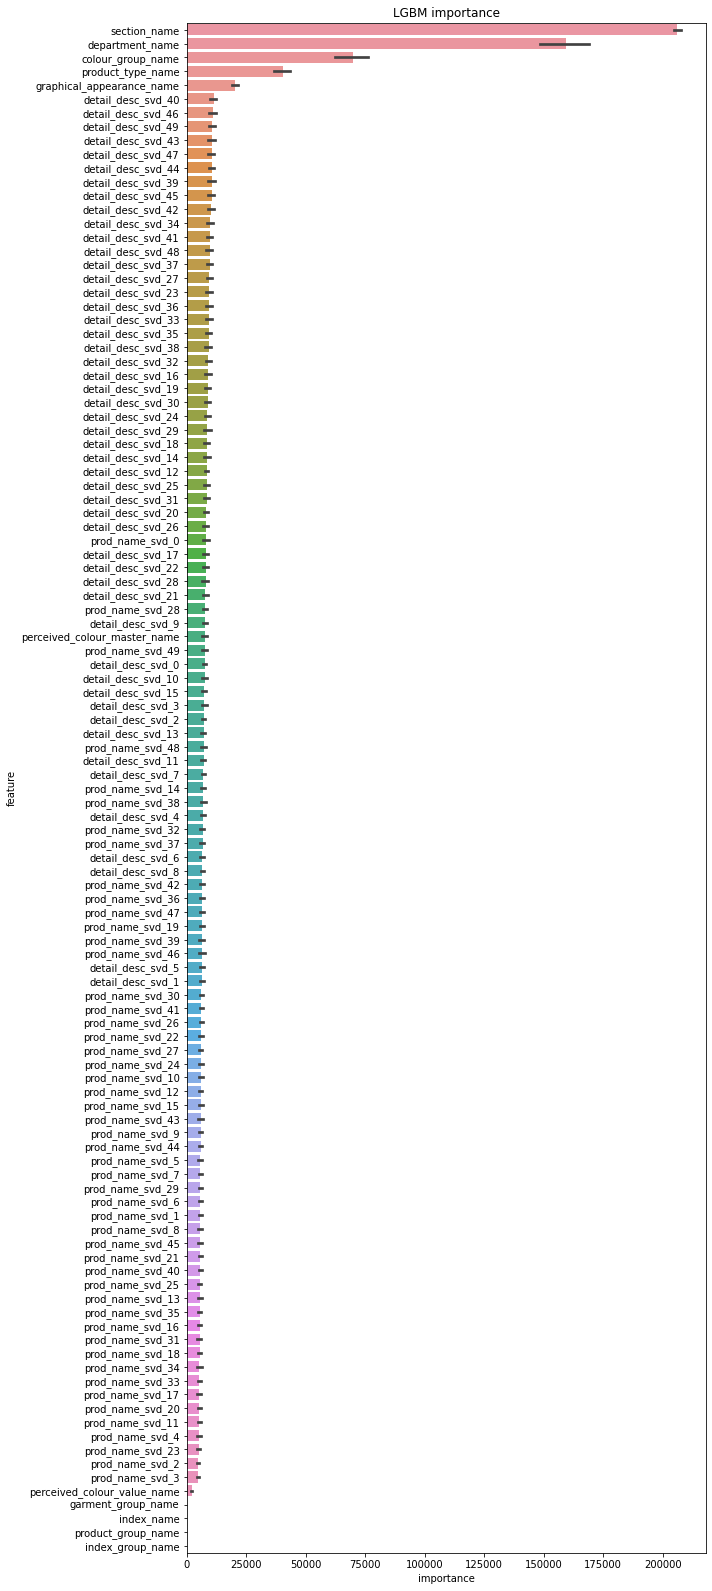

In [15]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

結果

In [16]:
print('RMSE : ', '{:.5f}'.format(mean_squared_error(oof['1st_week_sales'], oof['1st_week_sales_pred'], squared=False)))
print('MAE  : ', '{:.5f}'.format(mean_absolute_error(oof['1st_week_sales'], oof['1st_week_sales_pred'])))
print('相関係数  : ', '{:.5f}'.format(oof[['1st_week_sales', '1st_week_sales_pred']].corr().iat[0,1]))
print('順位相関  : ', '{:.5f}'.format(oof[['1st_week_sales', '1st_week_sales_pred']].corr(method='spearman').iat[0,1]))

RMSE :  677.97793
MAE  :  206.75151
相関係数  :  0.55790
順位相関  :  0.70129


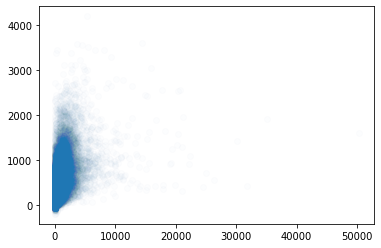

In [17]:
plt.scatter(oof['1st_week_sales'], oof['1st_week_sales_pred'], alpha=0.01)

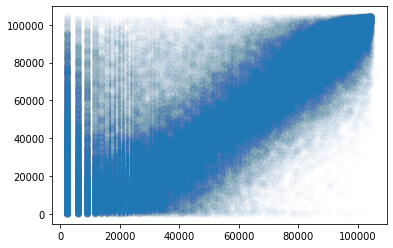

In [18]:
plt.scatter(oof['1st_week_sales'].rank(), oof['1st_week_sales_pred'].rank(), alpha=0.01)

In [19]:
usecols = ['article_id', '1st_week_sales_dat', '1st_week_sales_pred']
result = pd.concat([oof[usecols], test[usecols]])
result.to_csv(OUTPUT_DIR + f'{exp_name}/result.csv', index=False)
result

,article_id,1st_week_sales_dat,1st_week_sales_pred
0,0108775015,2018-09-20,1367.253467
1,0108775044,2018-09-20,1028.549809
2,0108775051,2018-09-20,1827.387403
3,0110065001,2018-09-20,608.766566
4,0110065002,2018-09-20,547.775709
...,...,...,...
105529,0949323002,2020-09-23,216.870465
105533,0950449002,2020-09-23,5.683309
105535,0952937003,2020-09-23,229.787020
105540,0957375001,2020-09-23,136.677508
